In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from google.colab import drive

drive.mount('/content/drive')
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Mounted at /content/drive
Num GPUs Available: 1


import 256x256x1 images and their masks from drive into numpy arrays

In [2]:
augmented_icm_dir = '/content/drive/MyDrive/pfa-augmented-dataset1/GT_ICM'
augmented_images_dir = '/content/drive/MyDrive/pfa-augmented-dataset1/Images'

images = []
icm_masks = []
SIZE = 256

file_names = os.listdir(augmented_images_dir)

for file_name in file_names:
    image_path = os.path.join(augmented_images_dir, file_name)
    icm_mask_path = os.path.join(augmented_icm_dir, file_name.replace('.png', ' ICM_Mask.png'))

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    icm_mask = cv2.imread(icm_mask_path, cv2.IMREAD_GRAYSCALE)

    image = cv2.resize(image, (SIZE, SIZE))
    icm_mask = cv2.resize(icm_mask, (SIZE, SIZE))

    image = np.expand_dims(image, axis=-1) / 255.0
    icm_mask = np.expand_dims(icm_mask, axis=-1) / 255.0

    images.append(image)
    icm_masks.append(icm_mask)

images = np.array(images)
icm_masks = np.array(icm_masks)

print(images.shape)
print(icm_masks.shape)

(747, 256, 256, 1)
(747, 256, 256, 1)


In [4]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def iou_metric(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, K.floatx())
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

def jaccard_distance(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou_metric(y_true_flatten, y_pred_flatten)

In [5]:
def spatial_attention(input_feature):
    avg_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_feature) # captures smooth context
    max_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_feature) # highlights salient features

    concat = tf.keras.layers.Concatenate(axis=-1)([avg_pool, max_pool])

    attention = tf.keras.layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)

    return tf.keras.layers.Multiply()([input_feature, attention])

def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    # This is inspired by the Squeeze-and-Excitation (SE) Block,
    # where they "squeeze" the channel descriptor into a smaller
    # bottleneck layer, then "excite" it back.
    shared_dense_one = tf.keras.layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_dense_two = tf.keras.layers.Dense(channel, activation='sigmoid', kernel_initializer='he_normal', use_bias=True)

    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = tf.keras.layers.Reshape((1, 1, channel))(avg_pool)
    avg_out = shared_dense_two(shared_dense_one(avg_pool))

    max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_feature)
    max_pool = tf.keras.layers.Reshape((1, 1, channel))(max_pool)
    max_out = shared_dense_two(shared_dense_one(max_pool))

    out = tf.keras.layers.Add()([avg_out, max_out])
    return tf.keras.layers.Multiply()([input_feature, out])

def scale_attention(features_list):
    num_features = len(features_list)
    concat = tf.keras.layers.Concatenate(axis=-1)(features_list)

    attention_weights = tf.keras.layers.Conv2D(num_features, kernel_size=1, padding='same')(concat)
    attention_weights = tf.keras.layers.BatchNormalization()(attention_weights)
    attention_weights = tf.keras.layers.Activation('sigmoid')(attention_weights)

    split_weights = tf.split(attention_weights, num_features, axis=-1)

    weighted_inputs = []
    for i, inp in enumerate(features_list):
        weighted_inputs.append(tf.keras.layers.Multiply()([inp, split_weights[i]]))

    output = tf.keras.layers.Add()(weighted_inputs)

    return output

In [1]:
def conv_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding="same", kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding="same", kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = tf.keras.layers.MaxPooling2D((2, 2))(c)
    return c, p

def decoder_block(x, skip, filters):
    x = tf.keras.layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

In this section, we will implement unet with spatial attention mechanism.

In [ ]:
def decoder_blocksp(x, skip, filters):
    skip = spatial_attention(skip)
    x = tf.keras.layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unetsp(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)
    b1 = tf.keras.layers.Dropout(0.5)(b1)

    d1 = decoder_blocksp(b1, s4, 512)
    d2 = decoder_blocksp(d1, s3, 256)
    d3 = decoder_blocksp(d2, s2, 128)
    d4 = decoder_blocksp(d3, s1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return tf.keras.Model(inputs, outputs)

In [ ]:
model = build_unetsp(input_shape=(SIZE, SIZE, 1))
model.compile(optimizer="Adam",
              loss=bce_dice_loss,
              metrics=[iou_metric])

X_train, X_val, y_train, y_val = train_test_split(images, icm_masks, test_size=0.2, random_state=42)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=40, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-5, patience=5, factor=0.5, verbose=1),
]

history = model.fit(
    X_train, y_train,
    epochs=200,
    validation_data=(X_val, y_val),
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - iou_metric: 0.2901 - loss: 1.0344 - val_iou_metric: 0.0716 - val_loss: 8.3751 - learning_rate: 0.0010
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 37s 970ms/step - iou_metric: 0.5689 - loss: 0.4857 - val_iou_metric: 0.1125 - val_loss: 9.4099 - learning_rate: 0.0010
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 902ms/step - iou_metric: 0.5819 - loss: 0.4421 - val_iou_metric: 0.1863 - val_loss: 1.7591 - learning_rate: 0.0010
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 961ms/step - iou_metric: 0.6741 - loss: 0.3281 - val_iou_metric: 0.1427 - val_loss: 4.4469 - learning_rate: 0.0010
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 966ms/step - iou_metric: 0.6587 - loss: 0.3348 - val_iou_metric: 0.3282 - val_loss: 1.2276 - learning_rate: 0.0010
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 908ms/step - iou_metric: 0.7390 - loss: 0.2497 - val_iou_metric: 0.3877 - val_loss: 1.0616 - learning_rate: 0.0010
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 965ms/step 

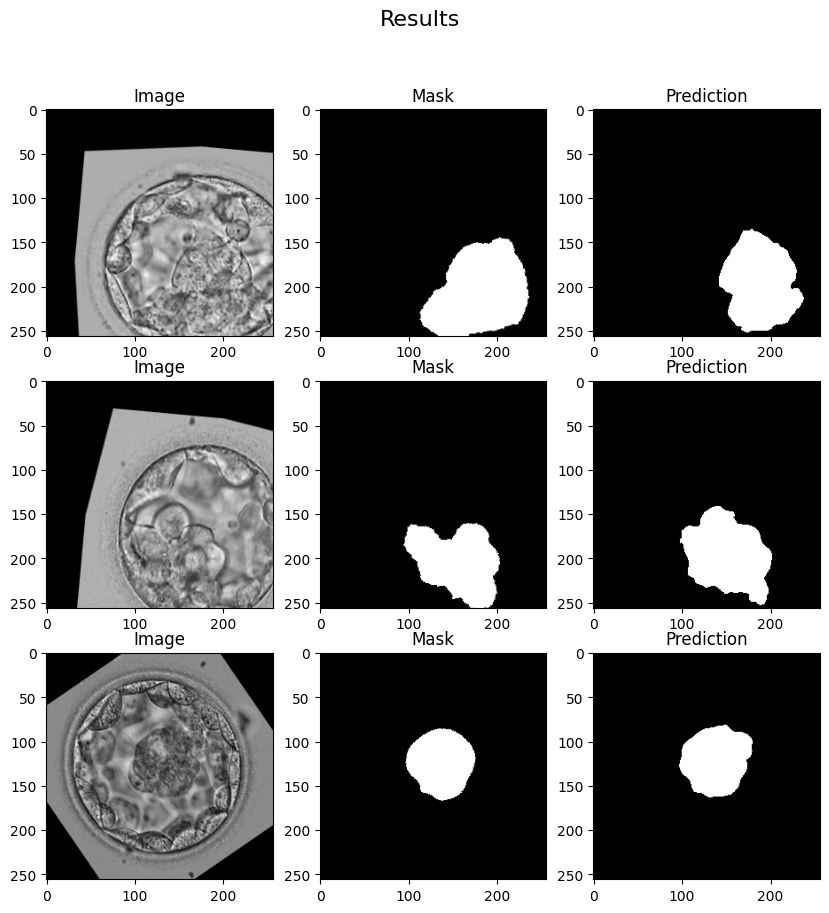

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

j = np.random.randint(0, X_val.shape[0], 3)
for i in range(3):
    ax[i, 0].imshow(X_val[j[i]], cmap='gray')
    ax[i, 0].set_title('Image')

    ax[i, 1].imshow(y_val[j[i]], cmap='gray')
    ax[i, 1].set_title('Mask')

    # Get prediction, apply threshold
    pred = model.predict(np.expand_dims(X_val[j[i]], 0), verbose=0)[0]
    pred = (pred > 0.5).astype(np.uint8)

    ax[i, 2].imshow(pred, cmap='gray')
    ax[i, 2].set_title('Prediction')

fig.suptitle('Results', fontsize=16)
plt.show()

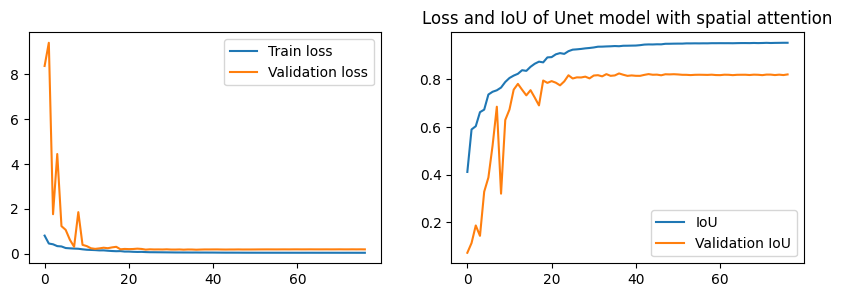

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
plt.title('Loss and IoU of Unet model with spatial attention')
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["iou_metric"], label="IoU")
ax[1].plot(history.epoch, history.history["val_iou_metric"], label="Validation IoU")
ax[1].legend()
plt.show()

In [ ]:
model.evaluate(X_val, y_val)

5/5 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - iou_metric: 0.8231 - loss: 0.1744


[0.17598123848438263, 0.8242599368095398]

We will try now Unet with channel attention.

In [7]:
def decoder_blockch(x, skip, filters):
    skip = channel_attention(skip)
    x = tf.keras.layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unetch(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)
    b1 = tf.keras.layers.Dropout(0.5)(b1)

    d1 = decoder_blockch(b1, s4, 512)
    d2 = decoder_blockch(d1, s3, 256)
    d3 = decoder_blockch(d2, s2, 128)
    d4 = decoder_blockch(d3, s1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return tf.keras.Model(inputs, outputs)

In [8]:
model = build_unetch(input_shape=(SIZE, SIZE, 1))
model.compile(optimizer="Adam",
              loss=bce_dice_loss,
              metrics=[iou_metric])

history = model.fit(
    X_train, y_train,
    epochs=200,
    validation_data=(X_val, y_val),
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - iou_metric: 0.2600 - loss: 1.1925 - val_iou_metric: 0.0824 - val_loss: 203.2932 - learning_rate: 0.0010
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 71s 967ms/step - iou_metric: 0.5749 - loss: 0.5639 - val_iou_metric: 0.0809 - val_loss: 190.2375 - learning_rate: 0.0010
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 931ms/step - iou_metric: 0.6403 - loss: 0.4107 - val_iou_metric: 0.0818 - val_loss: 1.4785 - learning_rate: 0.0010
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 880ms/step - iou_metric: 0.6741 - loss: 0.3448 - val_iou_metric: 0.1905 - val_loss: 1.5778 - learning_rate: 0.0010
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 943ms/step - iou_metric: 0.7285 - loss: 0.2726 - val_iou_metric: 0.1835 - val_loss: 1.0561 - learning_rate: 0.0010
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 944ms/step - iou_metric: 0.7158 - loss: 0.2792 - val_iou_metric: 0.3397 - val_loss: 0.8246 - learning_rate: 0.0010
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 936ms/s

In [9]:
model.evaluate(X_val, y_val)

5/5 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - iou_metric: 0.8109 - loss: 0.1816


[0.17743158340454102, 0.817021369934082]

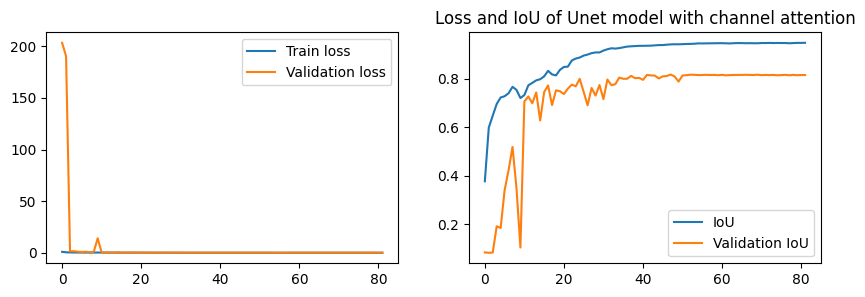

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
plt.title('Loss and IoU of Unet model with channel attention')
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["iou_metric"], label="IoU")
ax[1].plot(history.epoch, history.history["val_iou_metric"], label="Validation IoU")
ax[1].legend()
plt.show()

Now, we will combine the three attention modules in the same CA-net model.

In [2]:
def canet(input_shape=(256, 256, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    c1, p1 = encoder_block(inputs, 16)  # scale1
    c2, p2 = encoder_block(p1, 32)      # scale2
    c3, p3 = encoder_block(p2, 64)      # scale3
    c4, p4 = encoder_block(p3, 128)     # scale4
    c5 = conv_block(p4, 256)            # scale5

    # Bridge with SA1 and CA1
    sa1 = spatial_attention(c5)
    ca1 = channel_attention(sa1)

    # Decoder with attention
    u4 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(ca1)
    sa2 = spatial_attention(c4)
    u4 = tf.keras.layers.Multiply()([u4, sa2])
    ca2 = channel_attention(u4)
    d4 = decoder_block(ca2, c4, 128)

    u3 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d4)
    sa3 = spatial_attention(c3)
    u3 = tf.keras.layers.Multiply()([u3, sa3])
    ca3 = channel_attention(u3)
    d3 = decoder_block(ca3, c3, 64)

    u2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d3)
    sa4 = spatial_attention(c2)
    u2 = tf.keras.layers.Multiply()([u2, sa4])
    ca4 = channel_attention(u2)
    d2 = decoder_block(ca4, c2, 32)

    d1 = decoder_block(d2, c1, 16)

    # Multi-scale feature fusion (scale1 to scale4 outputs)
    f1 = tf.keras.layers.Conv2D(16, (1, 1), padding='same')(d1)
    f2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d2)
    f3 = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(d3)
    f4 = tf.keras.layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(d4)

    fusion = scale_attention([f1, f2, f3, f4])
    fusion = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(fusion)

    output = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(fusion)

    return tf.keras.Model(inputs, output, name="CANet")

In [ ]:
model = canet(input_shape=(SIZE, SIZE, 1))
model.compile(optimizer="Adam",
              loss=bce_dice_loss,
              metrics=[iou_metric])

history = model.fit(
    X_train, y_train,
    epochs=200,
    validation_data=(X_val, y_val),
    batch_size=16,
    callbacks=callbacks
)